In [15]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))


In [16]:
import pandas as pd

df = pd.read_csv("../data/AI_tickets.csv")
df.head()

,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


In [17]:
from src.preprocessing import preprocess_dataframe

df = preprocess_dataframe(df, "ticket_text")

# Verify column creation
assert "processed_text" in df.columns, "processed_text column missing"

df[["ticket_text", "processed_text"]].head()


,ticket_text,processed_text
0,Payment issue for my SmartWatch V2. I was unde...,payment issue smartwatch v I underbilled order
1,Can you tell me more about the UltraClean Vacu...,tell I ultraclean vacuum warranty also availab...
2,I ordered SoundWave 300 but got EcoBreeze AC i...,I order soundwave get ecobreeze ac instead ord...
3,Facing installation issue with PhotoSnap Cam. ...,face installation issue photosnap cam setup fa...
4,Order #30903 for Vision LED TV is 13 days late...,order vision lead tv day late order march also...


In [18]:
print("Average processed text length:",
      df["processed_text"].str.len().mean())

assert df["processed_text"].str.len().mean() > 0, "processed_text is empty"
print("processed_text verified ✔")


Average processed text length: 47.713
processed_text verified ✔


In [19]:
from src.feature_engineering import (
    add_text_length,
    add_sentiment_score,
    build_tfidf_features,
    combine_features
)


In [20]:
# TF-IDF features (TEXT)
X_tfidf, tfidf_vectorizer = build_tfidf_features(df["processed_text"])

# Numeric features
series  = df["processed_text"]
length_feat = add_text_length(series)
sentiment_feat = add_sentiment_score(series)

# Combine all features
X = combine_features(X_tfidf, length_feat, sentiment_feat)

print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (1000, 545)


In [21]:
y_issue = df["issue_type"]
y_urgency = df["urgency_level"]

print("Issue labels:", y_issue.unique())
print("Urgency labels:", y_urgency.unique())


Issue labels: ['Billing Problem' 'General Inquiry' 'Wrong Item' 'Installation Issue'
 'Late Delivery' 'Product Defect' nan 'Account Access']
Urgency labels: ['Medium' nan 'Low' 'High']


In [22]:
df_issue = df[df["issue_type"].notna()].copy()

X_issue_tfidf, vec_issue = build_tfidf_features(df_issue["processed_text"])
len_issue = add_text_length(df_issue["processed_text"])
sent_issue = add_sentiment_score(df_issue["processed_text"])

X_issue = combine_features(X_issue_tfidf, len_issue, sent_issue)
y_issue = df_issue["issue_type"]


In [23]:
df_urgency = df[df["urgency_level"].notna()].copy()

X_urg_tfidf, vec_urg = build_tfidf_features(df_urgency["processed_text"])
len_urg = add_text_length(df_urgency["processed_text"])
sent_urg = add_sentiment_score(df_urgency["processed_text"])

X_urgency = combine_features(X_urg_tfidf, len_urg, sent_urg)
y_urgency = df_urgency["urgency_level"]


In [24]:
# Training issue type model
# Use only rows with issue_type available
df_issue = df[df["issue_type"].notna()].copy()

print("Issue dataset size:", df_issue.shape[0])
X_issue_tfidf, issue_vectorizer = build_tfidf_features(
    df_issue["processed_text"]
)

len_issue = add_text_length(df_issue["processed_text"])
sent_issue = add_sentiment_score(df_issue["processed_text"])

X_issue = combine_features(
    X_issue_tfidf,
    len_issue,
    sent_issue
)

y_issue = df_issue["issue_type"]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_issue, y_issue,
    test_size=0.2,
    random_state=42,
    stratify=y_issue
)

issue_model = LogisticRegression(max_iter=1000)
issue_model.fit(X_train, y_train)

y_pred = issue_model.predict(X_test)

print("Issue Type Classification Report")
print(classification_report(y_test, y_pred))


Issue dataset size: 924
Issue Type Classification Report
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        29
   Billing Problem       1.00      0.90      0.95        29
   General Inquiry       0.71      1.00      0.83        29
Installation Issue       1.00      0.90      0.95        29
     Late Delivery       1.00      0.86      0.93        22
    Product Defect       1.00      0.92      0.96        24
        Wrong Item       1.00      0.96      0.98        23

          accuracy                           0.94       185
         macro avg       0.96      0.93      0.94       185
      weighted avg       0.95      0.94      0.94       185



In [25]:
#Urgency type model
df_urg = df[df["urgency_level"].notna()].copy()

print("Urgency dataset size:", df_urg.shape[0])
X_urg_tfidf, urg_vectorizer = build_tfidf_features(
    df_urg["processed_text"]
)

len_urg = add_text_length(df_urg["processed_text"])
sent_urg = add_sentiment_score(df_urg["processed_text"])

X_urg = combine_features(
    X_urg_tfidf,
    len_urg,
    sent_urg
)

y_urg = df_urg["urgency_level"]
X_train, X_test, y_train, y_test = train_test_split(
    X_urg, y_urg,
    test_size=0.2,
    random_state=42,
    stratify=y_urg
)

urgency_model = LogisticRegression(max_iter=1000)
urgency_model.fit(X_train, y_train)

y_pred = urgency_model.predict(X_test)

print("Urgency Level Classification Report")
print(classification_report(y_test, y_pred))


Urgency dataset size: 948
Urgency Level Classification Report
              precision    recall  f1-score   support

        High       0.38      0.45      0.41        66
         Low       0.30      0.20      0.24        60
      Medium       0.34      0.38      0.36        64

    accuracy                           0.35       190
   macro avg       0.34      0.34      0.34       190
weighted avg       0.34      0.35      0.34       190



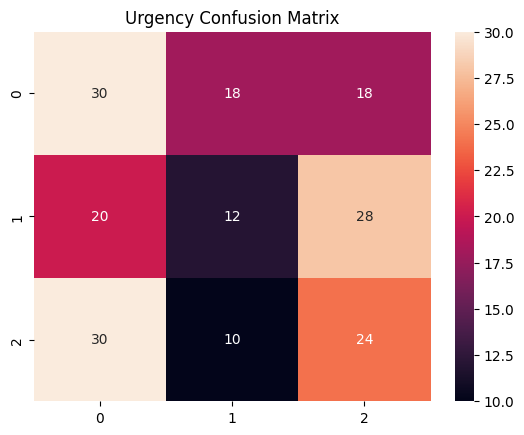

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Urgency Confusion Matrix")
plt.show()


In [27]:
from src.entity_extraction import extract_entities

product_list = df["product"].dropna().unique().tolist()

sample_text = df["ticket_text"].iloc[0]

entities = extract_entities(sample_text, product_list)
entities


{'products': ['SmartWatch V2'], 'dates': [], 'complaints': []}

In [28]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(issue_model, "../models/issue_model.pkl")
joblib.dump(urgency_model, "../models/urgency_model.pkl")
joblib.dump(issue_vectorizer, "../models/issue_vectorizer.pkl")
joblib.dump(urg_vectorizer, "../models/urgency_vectorizer.pkl")

print("Models and vectorizers saved")


Models and vectorizers saved
